In [10]:
import sys
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants
import os
import bigbadbrain as bbb
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy
from scipy.ndimage.filters import gaussian_filter
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d

from skimage.filters import threshold_triangle
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages')
import os
import statsmodels.api as sm
import cv2
import matplotlib.patches as mpatches
import psutil
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.colors import Normalize


%matplotlib inline
plt.rcParams.update({'font.size': 20})

from sklearn.feature_extraction.image import grid_to_graph
from mpl_toolkits.axes_grid1 import ImageGrid
import json
from matplotlib.ticker import FuncFormatter

import nibabel as nib

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import itertools
import random
from scipy.cluster import hierarchy
import matplotlib as mpl
from matplotlib.pyplot import cm

from scipy.interpolate import UnivariateSpline
from sklearn.linear_model import LinearRegression

import pickle
from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Ridge
import pickle

from scipy.ndimage.morphology import binary_erosion
from scipy.ndimage.morphology import binary_dilation



In [145]:
import brainsss
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from scipy.cluster import hierarchy
import matplotlib as mpl
from matplotlib.pyplot import cm
import random

In [6]:
func_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_116/func_0/'

In [7]:
###########################
### PREP VISUAL STIMULI ###
###########################

vision_path = os.path.join(func_path, 'visual')

### Load Photodiode ###
t, ft_triggers, pd1, pd2 = brainsss.load_photodiode(vision_path)
stimulus_start_times = brainsss.extract_stim_times_from_pd(pd2, t)

### Get Metadata ###
stim_ids, angles = brainsss.get_stimulus_metadata(vision_path)
print(F"Found {len(stim_ids)} presented stimuli.")

# *100 puts in units of 10ms, which will match fictrac
starts_angle_0 = [int(stimulus_start_times[i]*100) for i in range(len(stimulus_start_times)) if angles[i] == 0]
starts_angle_180 = [int(stimulus_start_times[i]*100) for i in range(len(stimulus_start_times)) if angles[i] == 180]
print(F"starts_angle_0: {len(starts_angle_0)}. starts_angle_180: {len(starts_angle_180)}")

loading photodiode data... done
Loaded from Pickle.
Found 269 presented stimuli.
starts_angle_0: 88. starts_angle_180: 88


In [8]:
fictrac_path = os.path.join(func_path, 'fictrac')
fictrac_raw = brainsss.load_fictrac(fictrac_path)

fps = 100
resolution = 10 #desired resolution in ms
expt_len = fictrac_raw.shape[0]/fps*1000
behaviors = ['dRotLabY', 'dRotLabZ']
fictrac = {}
for behavior in behaviors:
    if behavior == 'dRotLabY': short = 'Y'
    elif behavior == 'dRotLabZ': short = 'Z'
    fictrac[short] = brainsss.smooth_and_interp_fictrac(fictrac_raw, fps, resolution, expt_len, behavior)
xnew = np.arange(0,expt_len,resolution)

Text(0, 0.5, 'Angular Velocity')

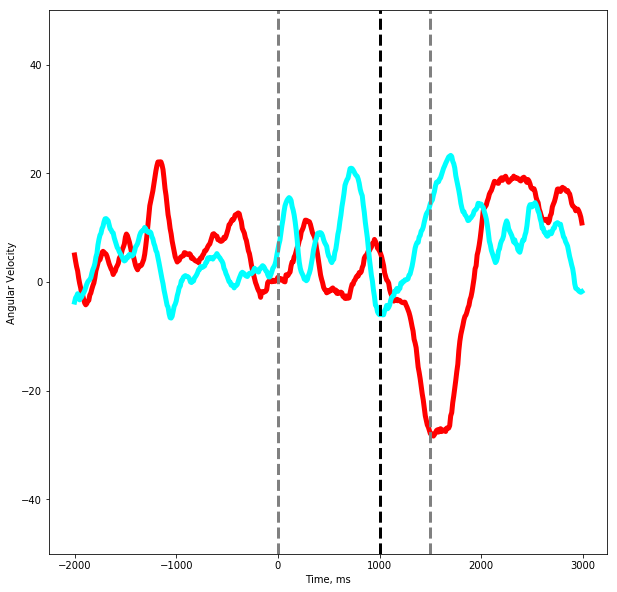

In [10]:
pre_window = 200 # in units of 10ms
post_window = 300

traces = []
for i in range(len(starts_angle_0)):
    trace = fictrac['Z'][starts_angle_0[i]-pre_window:starts_angle_0[i]+post_window]
    if len(trace) == pre_window + post_window: # this handles fictrac that crashed or was aborted or some bullshit
        traces.append(trace)
traces_0 = np.asarray(traces)
mean_trace_0 = np.mean(traces_0,axis=0)

traces = []
for i in range(len(starts_angle_180)):
    trace = fictrac['Z'][starts_angle_180[i]-pre_window:starts_angle_180[i]+post_window]
    if len(trace) == pre_window + post_window: # this handles fictrac that crashed or was aborted or some bullshit
        traces.append(trace)
traces_180 = np.asarray(traces)
mean_trace_180 = np.mean(traces_180,axis=0)

plt.figure(figsize=(10,10))
xs = np.arange(-pre_window,post_window)*10
plt.plot(xs, mean_trace_0,color='r',linewidth=5)
plt.plot(xs, mean_trace_180,color='cyan',linewidth=5)
plt.axvline(0,color='grey',lw=3,linestyle='--') # stim appears
plt.axvline(1000,color='k',lw=3,linestyle='--') # stim moves
plt.axvline(1500,color='grey',lw=3,linestyle='--') # grey
plt.ylim(-50,50)
plt.xlabel('Time, ms')
plt.ylabel('Angular Velocity')

In [11]:
traces_0.shape

(88, 500)

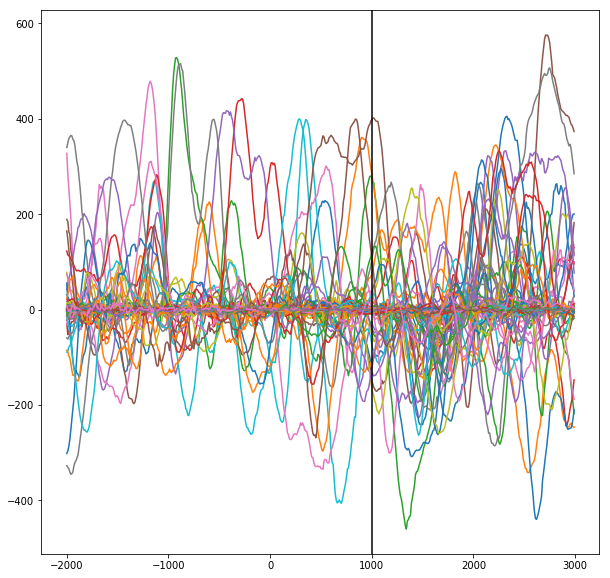

In [157]:
plt.figure(figsize=(10,10))
for i in range(traces_0.shape[0]):
    plt.plot(xs,traces_0[i,:])
plt.axvline(1000,color='k')

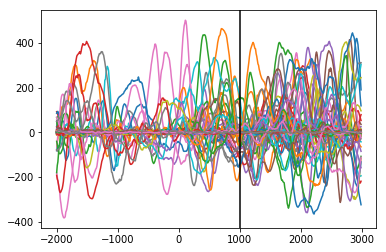

In [18]:
for i in range(traces_180.shape[0]):
    plt.plot(xs,traces_180[i,:])
plt.axvline(1000,color='k')

In [21]:
traces_0.shape

(88, 500)

In [27]:
model = AgglomerativeClustering(distance_threshold=0,
                                n_clusters=None,
                                memory=fictrac_path,
                                linkage='ward')
model = model.fit(traces_0)

In [28]:
### Create linkage matrix for dendrogram

counts = np.zeros(model.children_.shape[0])
n_samples = len(model.labels_)
for i, merge in enumerate(model.children_):
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            current_count += 1  # leaf node
        else:
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

linkage_matrix = np.column_stack([model.children_, model.distances_,
                                  counts]).astype(float)

In [143]:
cluster_colors

['#000080',
 '#0000bb',
 '#0000f6',
 '#0020ff',
 '#0054ff',
 '#008cff',
 '#00c0ff',
 '#0ff8e7',
 '#39ffbe',
 '#66ff90',
 '#90ff66',
 '#beff39',
 '#e7ff0f',
 '#ffd300',
 '#ffa300',
 '#ff6f00',
 '#ff3f00',
 '#f60b00',
 '#bb0000',
 '#800000']

In [171]:
###############
n_clusters = 20
###############

### Given a desired # of clusters, grab the distance threshold - needed for dendrogram
thresh = model.distances_[-n_clusters+1]

### Create the same # of colors as # of clusters
custom_cmap = cm.jet(np.linspace(0, 1, n_clusters))
cluster_colors = [mpl.colors.rgb2hex(rgb[:3]) for rgb in custom_cmap]
#random.shuffle(cluster_colors)

# set colors for dendrogram
# note clusters with only one entry will color so we need to skip
for n in np.unique(cluster_ids):
    print(len(np.where(cluster_ids==n)[0]))
hierarchy.set_link_color_palette(cluster_colors)

### Grab the cluster ids
cluster_ids = fcluster(linkage_matrix, t=n_clusters, criterion='maxclust')

### mean cluster responses

cluster_responses = []
for n in np.unique(cluster_ids):
    cluster_response = np.mean(traces_0[cluster_ids==n,:], axis=0)
    cluster_responses.append(cluster_response)

2
2
2
1
6
1
2
2
1
1
5
1
33
13
4
1
1
1
3
6


In [175]:
for n in np.unique(cluster_ids):
    print(n,len(np.where(cluster_ids==n)[0]))

1 2
2 2
3 2
4 1
5 6
6 1
7 2
8 2
9 1
10 1
11 5
12 1
13 33
14 13
15 4
16 1
17 1
18 1
19 3
20 6


In [177]:
np.where(cluster_ids==14)[0]

array([ 2, 11, 15, 16, 23, 27, 32, 37, 38, 40, 42, 78, 82])

In [173]:
cluster_ids

array([19,  7, 14, 13, 20, 17, 11, 13, 13, 13, 20, 14,  6, 11, 13, 14, 14,
        5, 13,  8, 13,  3, 13, 14, 13, 13, 13, 14, 13, 11,  7, 20, 14, 13,
       20, 13,  8, 14, 14, 13, 14,  5, 14, 13, 13, 13, 13, 18, 13, 13, 15,
       15,  1,  2,  2, 13, 13, 15, 13, 10,  5, 13,  5, 19, 19, 13, 16, 13,
        9, 15, 11, 13, 13, 13,  5,  4, 11,  1, 14,  5, 20, 13, 14, 20, 13,
        3, 13, 12], dtype=int32)

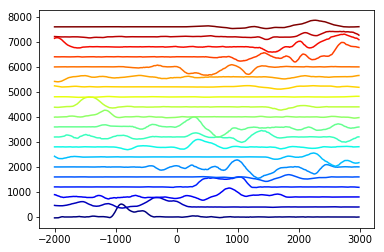

In [172]:
for n in range(n_clusters):
    plt.plot(xs,cluster_responses[n]+n*400,color=cluster_colors[n])

In [141]:
thresh

2526.0276908526616

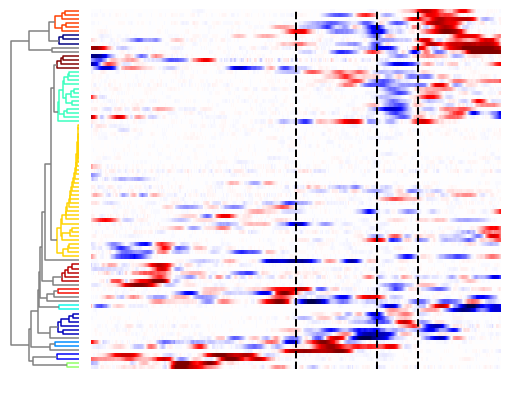

In [163]:
fig = plt.figure(figsize=(10,10))

### dendrogram ###
ax_dendrogram = fig.add_axes([1, .3, .1, .5])
ax_dendrogram.axis('off')
dend = dendrogram(linkage_matrix,
           truncate_mode=None,
           p=0,
           color_threshold=thresh,
           no_labels=True,
           distance_sort=True,
           above_threshold_color='grey',
           orientation='left');

### all resp ###
ax_dend = fig.add_axes([.9, .3, 1, .5])
ax_dend.imshow(traces_0[dend['leaves'][::-1],:],vmin=-400,vmax=400,aspect=5,cmap='seismic')
ax_dend.axis('off')
for line in [250,350,400]:
    ax_dend.axvline(line,color='k',linestyle='--',lw=2)

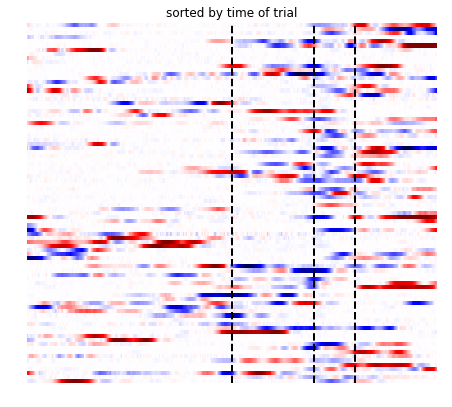

In [126]:
fig = plt.figure(figsize=(10,10))

### all resp ###
ax_dend = fig.add_axes([.9, .3, 1, .5])
plt.title('sorted by time of trial')
ax_dend.imshow(traces_0,vmin=-400,vmax=400,aspect=5,cmap='seismic')
ax_dend.axis('off')
for line in [250,350,400]:
    ax_dend.axvline(line,color='k',linestyle='--',lw=2)

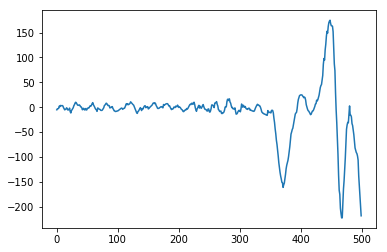

In [159]:
plt.plot(traces_0[2])

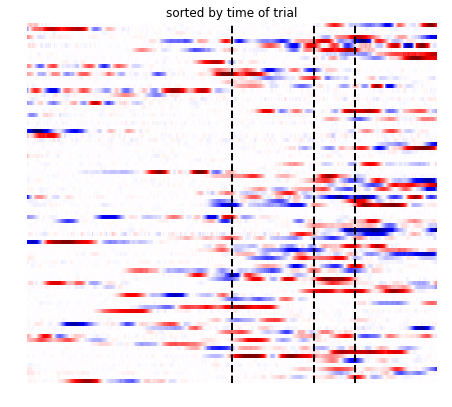

In [127]:
fig = plt.figure(figsize=(10,10))

### all resp ###
ax_dend = fig.add_axes([.9, .3, 1, .5])
plt.title('sorted by time of trial')
ax_dend.imshow(traces_180,vmin=-400,vmax=400,aspect=5,cmap='seismic')
ax_dend.axis('off')
for line in [250,350,400]:
    ax_dend.axvline(line,color='k',linestyle='--',lw=2)

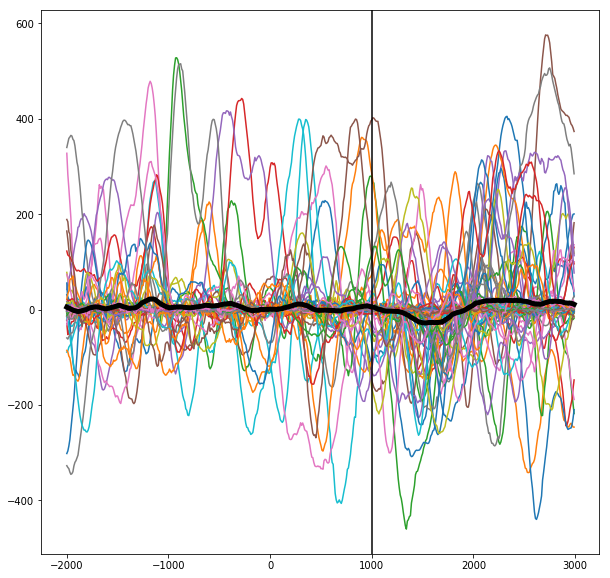

In [44]:
plt.figure(figsize=(10,10))
for i in range(traces_0.shape[0]):
    plt.plot(xs,traces_0[i,:])
plt.axvline(1000,color='k')
plt.plot(xs, mean_trace_0,color='k',linewidth=5)

In [102]:
a = {'a':1,'b':2}
b = a.get('c')

In [104]:
b is None

True

In [ ]:
np.asarray(starts_angle_0)*10

In [ ]:
list_in_ms = [i*10 for i in starts_angle_0]

In [11]:
starts_angle_0

[7364,
 9583,
 12354,
 13462,
 14569,
 15123,
 16231,
 17893,
 19001,
 20110,
 23438,
 24546,
 26762,
 28979,
 29532,
 32303,
 33412,
 35627,
 36181,
 38952,
 41168,
 41722,
 50896,
 52558,
 55328,
 55881,
 56990,
 58097,
 59759,
 60868,
 62529,
 63637,
 66407,
 68069,
 69731,
 71947,
 73055,
 74163,
 76932,
 77487,
 79702,
 81917,
 84133,
 85796,
 93861,
 96631,
 98293,
 98847,
 99955,
 101617,
 102725,
 103279,
 105495,
 106049,
 109374,
 111036,
 112144,
 114914,
 116022,
 117130,
 119346,
 120455,
 122117,
 123780,
 127103,
 127657,
 136830,
 139599,
 140153,
 141815,
 143477,
 144031,
 145138,
 146800,
 148461,
 149570,
 152339,
 153448,
 155663,
 156216,
 158986,
 160094,
 162309,
 164525,
 165634,
 167850,
 169512,
 171728]

In [ ]:
brain_path = os.path.join(func_path, 'functional_channel_2_moco_zscore_highpass.h5')

In [13]:
timestamps = brainsss.load_timestamps(os.path.join(func_path, 'imaging'), file='functional.xml')

Trying to load timestamp data from hdf5 file.
Success.


In [14]:
timestamps.shape

(3384, 49)

In [19]:
z=-1
timestamps[-1,0]

1799846.1113749999

In [ ]:
# load slice 20
# interpolate
# make interp object
interp1d
# set stim times to closest datapoint
# loop over all presentations and average

In [20]:
np.arange(0, 9, 0.1)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
       2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8,
       3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1,
       5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2, 6.3, 6.4,
       6.5, 6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7,
       7.8, 7.9, 8. , 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9])